In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteDynamics/9LFbr.ji for SatelliteDynamics [0e7c1a32-1b9f-5532-88a4-e668712d6a4c]
└ @ Base loading.jl:1184
┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteTasking/HFrko.ji for SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1184


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 110

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);

Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Simulating perturbed orbit 6
Simulating perturbed orbit 7
Simulating perturbed orbit 8
Simulating perturbed orbit 9
Simulating perturbed orbit 10
Simulating perturbed orbit 11
Simulating perturbed orbit 12
Simulating perturbed orbit 13
Simulating perturbed orbit 14
Simulating perturbed orbit 15
Simulating perturbed orbit 16
Simulating perturbed orbit 17
Simulating perturbed orbit 18
Simulating perturbed orbit 19
Simulating perturbed orbit 20
Simulating perturbed orbit 21
Simulating perturbed orbit 22
Simulating perturbed orbit 23
Simulating perturbed orbit 24
Simulating perturbed orbit 25
Simulating perturbed orbit 26
Simulating perturbed orbit 27
Simulating perturbed orbit 28
Simulating perturbed orbit 29
Simulating perturbed orbit 30
Simulating perturbed orbit 31
Simulating perturbed orbit 32
Simulating perturbed orbit 33
Simulating perturbe

In [3]:
# Compute True and perturbed collects

# Load test images
# @time images = load_images("../data/landsat_test_150.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_300.json", dwell_time=5.0);
@time images = load_images("../data/landsat_test_600.json", dwell_time=5.0);
num_images = length(images)

# Compute true and perturbed opportunities
@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);

# 
@time collects = compute_collects_by_number(true_opportunities, 10);

# Compute feasible collects
image_collects = group_image_collects(collects) # Group collects by image
num_feasible   = 0
for img in keys(image_collects)
    if length(image_collects[img]) > 0
        num_feasible += 1
    end
end
pct_feasible = num_feasible/num_images*100

println("$num_feasible out of $num_images images have collection opportunities.")

  0.298139 seconds (710.69 k allocations: 37.499 MiB, 5.23% gc time)
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Computing opportunities for perturbed orbit: 6
Computing opportunities for perturbed orbit: 7
Computing opportunities for perturbed orbit: 8
Computing opportunities for perturbed orbit: 9
Computing opportunities for perturbed orbit: 10
Computing opportunities for perturbed orbit: 11
Computing opportunities for perturbed orbit: 12
Computing opportunities for perturbed orbit: 13
Computing opportunities for perturbed orbit: 14
Computing opportunities for perturbed orbit: 15
Computing opportunities for perturbed orbit: 16
Computing opportunities for perturbed orbit: 17
Computing opportunities for perturbed orbit: 18
Computing opportunities for perturbed orbit: 19
Computing opportunities for 

In [4]:
println(sdev_diff[1, :])
println(sdev_diff[2, :])
println(sdev_diff[3, :])
println(missing_opportunities)

[1.63843, 6.77692, 14.025, 17.7612, 24.3462, 32.1319, 35.9444, 43.0459, 45.7315, 53.9966, 60.7306, 63.8821, 71.7664, 77.836, 83.172, 89.041, 91.5558, 105.188, 107.119, 111.162, 114.694, 125.135, 128.178, 131.927]
[4.09923, 10.8855, 18.9514, 23.2655, 29.0616, 37.5313, 39.6001, 47.57, 50.2186, 57.3195, 65.5278, 67.6255, 75.6405, 82.0206, 84.5998, 93.4971, 95.5887, 110.224, 111.584, 115.96, 118.482, 128.765, 132.127, 134.078]
[5.16428, 6.00707, 6.30853, 7.17249, 6.54537, 7.25584, 4.98086, 6.32549, 6.87565, 6.17568, 6.84879, 6.96747, 6.83629, 5.62473, 5.73077, 8.16053, 5.81088, 9.39435, 7.07505, 9.40925, 7.70638, 9.06155, 12.0065, 18.2127]
[14, 93, 24, 54, 2, 97, 28, 112, 48, 149, 76, 178, 108, 161, 55, 46, 114, 35, 63, 47, 371, 77, 147, 221]


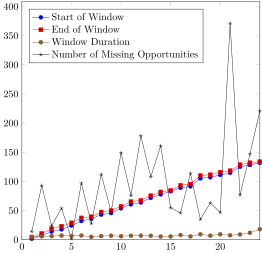

In [5]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [6]:
# Graph planning
@time path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
graph_path, graph_reward, graph_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

graph_feasible = sp_check_feasibility(graph_path, Function[constraint_agility_single_axis])
println("GRAPH Constraint Check: $(graph_feasible ? "PASS" : "FAIL")")

220.394055 seconds (966.00 M allocations: 44.419 GiB, 55.58% gc time)
Total planning reward: 546.0
Number of images collected: 546/600, 91.0
Number of feasible images collected: 546/552, 98.91304347826086
GRAPH Constraint Check: PASS


In [7]:
# MILP planning
@time path, reward, image_list = sp_milp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)
milp_path, milp_reward, milp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

milp_feasible = sp_check_feasibility(milp_path, Function[constraint_agility_single_axis])
println("MILP Constraint Check: $(milp_feasible ? "PASS" : "FAIL")")

Academic license - for non-commercial use only
Optimize a model with 782976 rows, 18322 columns and 1583170 nonzeros
Variable types: 0 continuous, 18322 integer (18322 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 18322 integer (18322 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.04s

Solved with dual simplex

Root relaxation: objective 5.520000e+02, 548 iterations, 0.87 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     552.0000000 18322.0000  3219%     -    1s
     0     0          -    0       552.00000  552.00000  0.00%     -    2s

Explored 0 nodes (1268 simplex iterations) in 2.54 seconds
Thread count was 12 (of 12 

In [8]:
# MDP Planning

# Pre-compute collect probability
@time collect_probs = compute_collect_probability(collects, perturbed_opportunities[1:10]);

312.549063 seconds (5.09 M allocations: 235.549 MiB, 0.01% gc time)


In [9]:
# Test MDP Forward Search Solution
@time path, reward, image_list = mdp_forward_search(collects, Function[constraint_agility_single_axis], 
                                                    images, collect_probs,
                                                    horizon=4000, gamma=0.7, search_depth=1);

mdp_path, mdp_reward, mdp_image_list = path, reward, image_list

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

mdp_feasible = sp_check_feasibility(path, Function[constraint_agility_single_axis])
println("MDP Constraint Check: $(mdp_feasible ? "PASS" : "FAIL")")

Number of all images: 600, Collected: 489, Missed: 111
 69.077179 seconds (650.21 M allocations: 22.875 GiB, 12.78% gc time)
Total planning reward: 489.0
Number of images collected: 489/600, 81.5
Number of feasible images collected: 489/552, 88.58695652173914
MDP Constraint Check: PASS


In [10]:
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(graph_path, perturbed_opportunities[11:end])

([144.0, 388.0, 449.0, 542.0, 532.0, 477.0, 468.0, 525.0, 111.0, 517.0  …  537.0, 78.0, 96.0, 519.0, 203.0, 224.0, 534.0, 97.0, 217.0, 537.0], 330.08, 186.8241046027146)

In [11]:
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(milp_path, perturbed_opportunities[11:end])

([79.0, 278.0, 383.0, 546.0, 531.0, 440.0, 408.0, 514.0, 56.0, 500.0  …  528.0, 46.0, 52.0, 517.0, 162.0, 195.0, 528.0, 46.0, 186.0, 525.0], 298.03, 200.65445724459053)

In [12]:
realized_rewards, mean_reward, sdev_reward = sp_compute_collect(mdp_path, perturbed_opportunities[11:end])

([142.0, 348.0, 429.0, 488.0, 486.0, 457.0, 442.0, 482.0, 115.0, 478.0  …  485.0, 82.0, 100.0, 481.0, 234.0, 262.0, 485.0, 98.0, 254.0, 483.0], 317.86, 163.57656718898747)